Genetic Algorithms (GAs) are a class of evolutionary algorithms inspired by the process of natural selection that belong to the larger class of evolutionary algorithms (EA). Genetic algorithms are commonly used to generate high-quality solutions to optimization and search problems by relying on bio-inspired operators such as mutation, crossover, and selection. These algorithms reflect the process of natural selection where the fittest individuals are selected for reproduction to produce offspring of the next generation.

**Key Concepts**
* Population: A set of candidate solutions to the given problem. Each candidate solution has a set of properties (its chromosomes or genotype) which can be mutated and altered.
* Chromosomes: A representation of a candidate solution. Often represented as strings of binary values, but can be represented by other structures depending on the problem domain.
* Fitness Function: A function that evaluates and assigns a fitness score to each candidate solution in the population. The fitness score determines how good a solution is.
* Selection: The process of choosing the fittest individuals from the population for reproduction. Selection methods include roulette wheel selection, tournament selection, etc.
* Crossover (Recombination): A genetic operator used to combine the genetic information of two parents to generate new offspring. It is one way to stochastically generate new solutions from an existing population.
* Mutation: A genetic operator that alters one or more gene values in a chromosome from its initial state. This process introduces new genetic structures in the population by changing the chromosomes of the offspring.
* Termination: The algorithm terminates when either a maximum number of generations have been produced, or a satisfactory fitness level has been reached for the population.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import tqdm as tq

# Set random seed for reproducibility
np.random.seed(42)

# Function to generate mock data for tasks and robots
def generate_mock_data(num_tasks=10, num_robots=5):
    task_durations = [x for x in range(11)]# Task durations
    task_priorities = [x for x in range(11)]   # Task priorities
    robot_efficiencies = [0.1,0.01,0.2,0.3,0.4] # Robot efficiencies  # Random robot efficiencies between 0.5 and 1.5
    print(f"task duration: {task_durations},\ntask_priorities: {task_priorities}, \nrobot_efficiencies: {robot_efficiencies}")
    return task_durations, task_priorities, robot_efficiencies
    

Fitness Function Calculation
The fitness function aims to minimize the total production time while ensuring a balanced
workload across robots and prioritizing critical tasks. It can be decomposed into several
components:
1. Total Production Time (Ttotal)
The total production time is determined by the robot that finishes last, taking into account the
efficiency of each robot. For each robot r, the time Tr spent on its assigned tasks is the sum of
the durations of these tasks divided by the robot's efficiency. The total production time is the
maximum time any robot takes to complete its tasks.

    Tr = ∑n∈tasks(r) DnXPn / Er
    Ttotal = max (T1, T2, ... , TR)

where:
• tasks(r) is the set of tasks assigned to robot r,
• Dn is the duration of task n,
• Pn is the priority weight of task n,
• Er is the efficiency of robot r,
• R is the total number of robots.
2. Workload Balance (B)
The workload balance penalizes uneven distribution of work among robots. It can be quantified
using the standard deviation of the total times across all robots.
B=σ(T1,T2,...,TR)
where σ is the standard deviation.
3. Fitness Function (F)
The fitness function combines Ttotal and B to evaluate the quality of an assignment. Since we
aim to minimize both the total production time and the imbalance in workload, a simple
approach could be to take the inverse of their sum.
F(I) = Ttotal + B

In [22]:

def fitness_function( assignment, task_durations, task_priorities, robot_efficiencies):
    """
    Calculates the fitness of a given task assignment.

    Args:
        task_durations: List of task durations.
        task_priorities: List of task priorities.
        robot_efficiencies: List of robot efficiencies.
        assignment: List of task assignments to robots.

    Returns:
        The fitness value.
    """

    # Calculate the total duration of tasks assigned to each robot
    robot_workloads = [0] * len(robot_efficiencies)
    for task, robot in enumerate(assignment):
        robot_workloads[robot] += task_durations[task] * task_priorities[task] / robot_efficiencies[robot]

    # Calculate the total time taken to complete all tasks
    T_total = max(robot_workloads)

    # Calculate the workload distribution among robots
    workload_distribution = np.std(robot_workloads)

    # Calculate the fitness value
    fitness = 1 / (T_total + workload_distribution)

    return fitness


In [23]:

def select_parents(population, fitness_values, pop_size, num_tasks, tournament_size=2):
    #! i dont understand this function
    parents = np.empty((pop_size, num_tasks), dtype=int)
    for i in range(pop_size):
        tournament_indices = np.random.choice(pop_size, tournament_size, replace=False)
        best_parent_idx = tournament_indices[np.argmin(fitness_values[tournament_indices])]
        parents[i] = population[best_parent_idx]
    return parents


In [24]:
def crossover(parents, crossover_rate, pop_size, num_tasks):
    offspring = np.empty((pop_size, num_tasks), dtype=int)
    for i in range(0, pop_size, 2):
        if np.random.rand() < crossover_rate:
            crossover_point = np.random.randint(1, num_tasks)
            offspring[i] = np.concatenate((parents[i, :crossover_point], parents[i+1, crossover_point:]))
            offspring[i+1] = np.concatenate((parents[i+1, :crossover_point], parents[i, crossover_point:]))
        else:
            offspring[i] = parents[i]
            offspring[i+1] = parents[i+1]
    return offspring

In [25]:
def mutate(offspring, mutation_rate, pop_size, num_tasks, num_robots):
    for i in range(len(offspring)-1):
        temp = offspring[i].copy()

        for j in range(len(temp)):
            if np.random.rand() < mutation_rate:
                offspring[i, j] = np.random.randint(num_robots)
    return offspring

selects the best :pop_size ammount of the offspring

In [26]:
def select_next_generation(combined_population, combined_fitness_values, pop_size):
    # Select next generation based on fitness values
    sorted_indices = np.argsort(combined_fitness_values)
    next_generation = combined_population[sorted_indices[:pop_size]]
    next_fitness_values = combined_fitness_values[sorted_indices[:pop_size]]
    return next_generation, next_fitness_values

In [27]:

def run_genetic_algorithm(task_durations, task_priorities, robot_efficiencies):
    # Hyperparameters
    pop_size = 50       #! why pop size cant be less then num_gen
    num_tasks = len(task_durations)
    num_robots = len(robot_efficiencies)
    crossover_rate = 0.9
    mutation_rate = 0.1
    num_generations = 100
    
    # Initialize population
    population = np.random.randint(num_robots, size=(pop_size, num_tasks))
    
    # Run genetic algorithm
    for generation in tq.tqdm(range(num_generations), desc ="evolv"):
        # Calculate fitness values
        fitness_values = np.array([fitness_function(population[i], task_durations, task_priorities, robot_efficiencies) for i in range(pop_size)])

        # Select parents
        parents = select_parents(population, fitness_values, pop_size, num_tasks)

        # Crossover
        offspring = crossover(parents, crossover_rate, pop_size, num_tasks)

        # Mutation
        offspring = mutate(offspring, mutation_rate, pop_size, num_tasks, num_robots)

        #evaluateing fitness of offsprings
        for i in offspring :
          offspring_fitness = fitness_function(i, task_durations, task_priorities, robot_efficiencies)

        # Combine population and offspring
        combined_population = np.vstack((population, offspring))
        combined_fitness_values = np.hstack((fitness_values, offspring_fitness))

        # Select next generation
        population, fitness_values = select_next_generation(combined_population, combined_fitness_values, pop_size)

    # Find best solution
    return population[np.argmax(fitness_values)]

In [28]:
def visualize_assignments_improved(solution, task_durations, task_priorities, robot_efficiencies):
    # Create a grid for visualization based on the solution provided
    grid = np.zeros((len(robot_efficiencies), len(task_durations)))
    for task_idx, robot_idx in enumerate(solution):
        grid[robot_idx, task_idx] = task_durations[task_idx]

    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "blue"])  # Custom colormap

    # Display the grid with task durations
    cax = ax.matshow(grid, cmap=cmap)
    fig.colorbar(cax, label='Task Duration (hours)')

    # Annotate each cell with task priority and duration
    for i in range(len(robot_efficiencies)):
        for j in range(len(task_durations)):
            ax.text(j, i, f'P{task_priorities[j]}\n{task_durations[j]}h', va='center', ha='center')


    # Set the ticks and labels for tasks and robots
    ax.set_xticks(np.arange(len(task_durations)))
    ax.set_yticks(np.arange(len(robot_efficiencies)))
    ax.set_xticklabels([f'Task {i+1}' for i in range(len(task_durations))], rotation=45, ha="left")
    ax.set_yticklabels([f'Robot {i+1} (Efficiency: {eff:.2f})' for i, eff in enumerate(robot_efficiencies)])

    plt.xlabel('Tasks')
    plt.ylabel('Robots')
    plt.title('Task Assignments with Task Duration and Priority')

    # Create a legend for task priorities
    priority_patches = [mpatches.Patch(color='white', label=f'Priority {i}') for i in range(1, 6)]
    plt.legend(handles=priority_patches, bbox_to_anchor=(1.20, 1), loc='upper left', title="Task Priorities")

    plt.tight_layout()
    plt.show()

task duration: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
task_priorities: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
robot_efficiencies: [0.1, 0.01, 0.2, 0.3, 0.4]


evolv: 100%|██████████| 100/100 [00:00<00:00, 184.05it/s]


best_solution: [4 2 4 2 0 4 1 2 0 1 1]


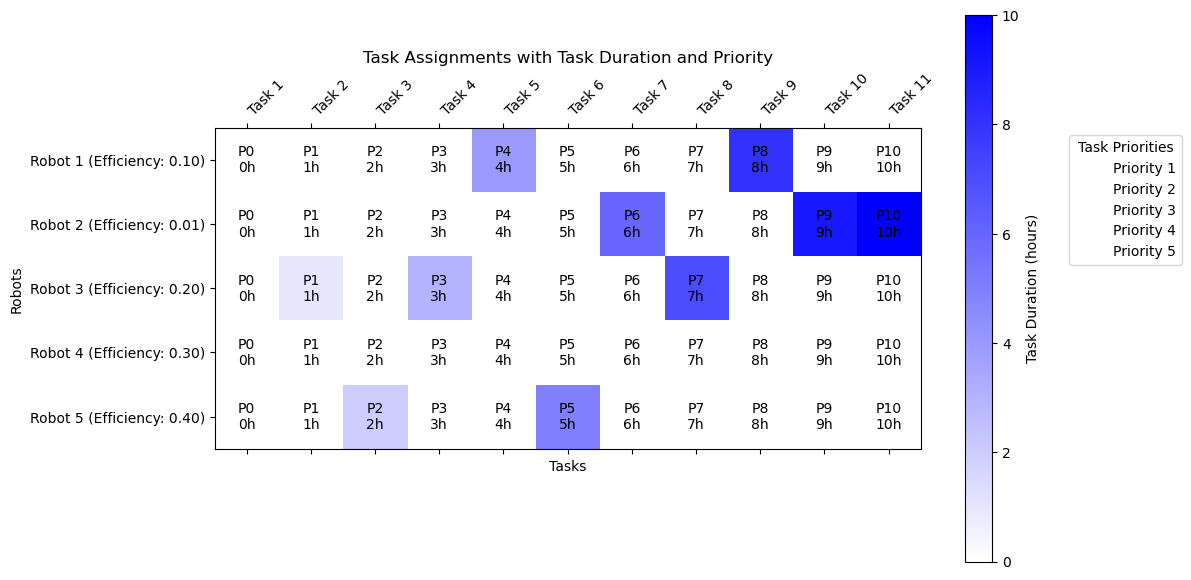

In [29]:
if __name__ == "__main__":
    num_tasks = 10
    num_robots = 5
    task_durations, task_priorities, robot_efficiencies = generate_mock_data(num_tasks, num_robots)

    # Run GA to find the best solution
    best_solution = run_genetic_algorithm(task_durations, task_priorities, robot_efficiencies)
    print(f"best_solution: {best_solution}")

    # Visualize the initial random assignment
    visualize_assignments_improved(best_solution, task_durations, task_priorities, robot_efficiencies)


In [30]:
print(np.random.randint(num_robots))

4
